### Proyecto

In [616]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import BaseScheduler
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import seaborn as sns

from collections import deque

from http.server import BaseHTTPRequestHandler, HTTPServer
import logging
import json
import re

from random import choices


In [617]:
class PlayerAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.actionPoints = 4
        self.extraActionPoints = 0
        self.totalAPUsed = 0
        self.isCarryingVictim = False
        self.isKnockedOut = False
        self.victimsRescued = 0
        self.wasKnockedOut = 0
        self.cellsVisited = 0
    
    # def move(self):
    #     if self.actionPoints > 0:
    #         possiblePositions = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
    #         availableIndexes = np.random.permutation(len(possiblePositions))
    #         for idx in availableIndexes:
    #             position = possiblePositions[idx]
    #             if self.model.grid.is_cell_empty(position):
    #                 self.model.grid.move_agent(self, position)
    #                 if self.model.cells[self.pos[0]][self.pos[1]] == 2:
    #                     self.model.cellsVisited += 1
    #                     self.actionPoints -= 2
    #                     break
    #                 else:
    #                     self.actionPoints -= 1
    #                     self.cellsVisited += 1
    #                     break

    # def extinguish(self, pos):
    #     if self.actionPoints < 2:
    #         return False
    #     if self.model.cells[pos[0]][pos[1]] == 1:
    #         self.model.cells[pos[0]][pos[1]] = 0
    #         self.actionPoints -= 1
    #         return True
    #     else:
    #         self.model.cells[pos[0]][pos[1]] = 0
    #         self.actionPoints -= 2
    #         return True
        
    # def moveTowards(self, target):
    #     x = target[0] - self.pos[0]
    #     y = target[1] - self.pos[1]
    #     newX = self.pos[0] + (1 if x > 0 else -1 if x < 0 else 0)
    #     newY = self.pos[1] + (1 if y > 0 else -1 if y < 0 else 0)
    #     newPos = (newX, newY)

    #     if self.model.grid.is_cell_empty(newPos):
    #         self.model.grid.move_agent(self, newPos)
    #         if self.isCarryingVictim and self.actionPoints < 4:
    #             self.actionPoints -= 2
    #         if self.model.cells[self.pos[0]][self.pos[1]] == 2:
    #             self.model.cellsVisited += 1
    #             self.actionPoints -= 2
    #         else:
    #             self.actionPoints -= 1
    #             self.cellsVisited += 1

    # def getExitRoute(self):
    #     return abs(self.pos[0] - self.model.exitPos[0]) + abs(self.pos[1] - self.model.exitPos[1])
    





In [618]:
# Funciones para leer el archvio con la descripción del tablero.

def load_scenario(file_path):
    """
    Procesa un archivo de texto con la configuración inicial del escenario y retorna los datos necesarios.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Leer la cuadrícula del escenario con las paredes
    walls = []
    for i in range(6):  # 6 filas de celdas
        row = lines[i].strip().split()
        walls.append([list(map(int, cell)) for cell in row])

    # walls = np.array(walls)  # Convertir a numpy array para facilitar operaciones

    # Leer los marcadores de puntos de interés
    markers = []
    for i in range(6, 9):  # 3 líneas de marcadores
        line = lines[i].strip().split()
        row, col, marker_type = int(line[0]), int(line[1]), line[2]
        markers.append((row, col, marker_type))  # Ajustar índices a 0-based

    # Leer los marcadores de fuego
    fires = []
    for i in range(9, 19):  # 10 líneas de marcadores de fuego
        line = lines[i].strip().split()
        row, col = int(line[0]), int(line[1])
        fires.append((row, col))

    # Leer las puertas
    doors = []
    for i in range(19, 27):  # 8 líneas de puertas
        line = lines[i].strip().split()
        r1, c1, r2, c2 = map(int, line)
        doors.append([[r1, c1], [r2, c2]])

    # Leer los puntos de entrada
    entry_points = []
    for i in range(27, 31):  # 4 líneas de puntos de entrada
        line = lines[i].strip().split()
        row, col = int(line[0]), int(line[1])
        entry_points.append((row, col))  # Ajustar índices a 0-based

    return walls, markers, fires, doors, entry_points

In [670]:
def get_grid(model):
  # grid = [[0] * 10 for _ in range(8)]
  grid = np.zeros( (model.grid.height, model.grid.width) )

  for content, (x, y) in model.grid.coord_iter(): 
    grid[y][x] = model.board[y][x]["fireState"]
    if model.board[y][x]["fireState"] == 1:
      grid[y][x] = 2
    if model.board[y][x]["fireState"] == 2:
      grid[y][x] = 3
    if model.board[y][x]["marker"] == 1:
      grid[y][x] = 4
    if model.board[y][x]["marker"] == 2:
      grid[y][x] = 5

  for agent in model.schedule.agents:
    x,y = agent.pos
    grid[y][x] = 1

    
  return grid

def get_wall_grid(model):
    wall_grid = []
    for i in range(0, model.grid.height):
        row = []
        for j in range(0, model.grid.width):
            cell = model.board[i][j]["wall"].copy()
            row.append(cell.copy())
        wall_grid.append(row)
    return wall_grid

def get_damage_grid(model):
  damage_grid = []
  for i in range(0, model.grid.height):
    row = []
    for j in range(0, model.grid.width):
      cell = model.board[i][j]["damage"].copy()
      row.append(cell.copy())
    damage_grid.append(row)
  return damage_grid

def get_door_grid(model):
  door_grid = []
  for i in range(0, model.grid.height):
    row = []
    for j in range(0, model.grid.width):
      cell = model.board[i][j]["door"].copy()
      row.append(cell.copy())
    door_grid.append(row)
  return door_grid

def get_marker_grid(model):
  marker_grid = []
  for i in range(0, model.grid.height):
    row = []
    for j in range(0, model.grid.width):
      cell = model.board[i][j]["marker"]
      row.append(cell)
    marker_grid.append(row)
  return marker_grid

def get_revealed_grid(model):
  revealed_grid = []
  for i in range(0, model.grid.height):
    row = []
    for j in range(0, model.grid.width):
      cell = model.board[i][j]["revealed"]
      row.append(cell)
    revealed_grid.append(row)
  return revealed_grid

def get_fire_grid(model):
  fire_grid = []
  for i in range(0, model.grid.height):
    row = []
    for j in range(0, model.grid.width):
      cell = model.board[i][j]["fireState"]
      row.append(cell)
    fire_grid.append(row)
  return fire_grid
# def get_damage(damage_grid):
#   damage = 0
#   for row in damage_grid:
#     for column in row:
#       for orientation in column:
#         damage += orientation
#   return damage

# def get_damage(model):
#     damage = 0
#     # Recorrer directamente el tablero del modelo para calcular el daño total
#     for row in model.board:
#         for cell in row:
#             damage += sum(cell["damage"])  # Sumar todos los valores en el array "damage"
#     return damage
  
# def get_agent_positions(model):
#   agent_data = []
#   for y in range(0, model.grid.height):
#     for x in range(0, model.grid.width):
#       agent = model.grid.get_cell_list_contents([(x, y)])
#       if isinstance(agent, PlayerAgent):  # Reemplaza YourAgentClass por la clase del agente que estás buscando
#         print("Agente encontrado:", agent)
#         agent_data.append({
#                 'id': agent.unique_id,
#                 'position': (x, y)
#             })
#   return agent_data

def get_agent_positions(model):
  agent_data = []
  for agent in model.schedule.agents:
    ida = agent.unique_id
    x,y = agent.pos
    agent_data.append([x, y, ida])
  return agent_data



# def get_agent_positions(model):
#     # Crear una lista para almacenar la información de los agentes
#     agent_info = []

#     # Iterar sobre todos los agentes programados en el modelo
#     for agent in model.schedule.agents:
#         # Obtener la posición del agente desde la cuadrícula
#         agent_position = model.grid.find_agent(agent)
#         # Añadir la información del agente a la lista
#         agent_info.append({
#             'id': agent.unique_id,
#             'position': agent_position
#         })

#     # Retornar la lista con la información de los agentes
#     return agent_info

In [655]:
def generate_board(width, height):
    board = []
    for i in range(0, height+2):
        row = []
        for j in range(0, width+2):
            cell = {"wall" : [0,0,0,0],"fireState" : 0, "marker" : 0, "revealed": 0, "damage" : [0,0,0,0], "door" : [0,0,0,0]}
            row.append(cell.copy())
        board.append(row)

    # print(board)
    # wall_board = np.zeros((width + 1, height + 1))
    # for row in wall_board:
    #     for cell in row:
    #         cell = {"Wall" : 0, "Damage" : 0, }
    return board #, wall_board

In [639]:
# Modelo para la simulación

class FireRescueModel(Model):
  def __init__(self, walls, markers, fires, doors, entry_points, players):
    super().__init__()
    self.victims = 0
    self.rescued = 0
    self.steps = 0
    self.ending = False
    self.false_markers = 5
    self.true_markers = 10
    self.grid = MultiGrid(10, 8, torus = False)
    self.schedule = BaseScheduler(self)
    self.datacollector = DataCollector( # Datos a recolectar para generar el reporte.
        model_reporters = {"Grid" : get_grid,
                           "WallGrid" : get_wall_grid,
                           "DamageGrid" : get_damage_grid,
                           "DoorsGrid" : get_door_grid,
                           "MarkerGrid" : get_marker_grid,
                           "RevealedGrid" : get_revealed_grid,
                           "FireGrid" : get_fire_grid,
                           "Steps" : lambda model: model.steps,
                           "Fire" : lambda model: sum(1 for i in range(0, 10) for j in range(0, 8) if model.board[j][i]["fireState"] == 2), # / model.fire_board.size,
                           "Damage" : lambda model: model.damage,
                           "Victims" : lambda model: model.victims,
                           "Rescued" : lambda model: model.rescued,
                           "GameEnd" : lambda model: model.ending,
                           "AgentInfo" : get_agent_positions},
                           
        # agent_reporters = {"Efficiency": lambda agent: agent.boxes_gathered / agent.energy_used,
        #                    "Resources_gathered": lambda agent: agent.boxes_gathered,
        #                    "Energy_used": lambda agent: agent.energy_used}
                           )


    width = 8
    height = 6
    self.board = generate_board(width, height) # Generar el tablero.
    self.damage = 0                                                                                
    
    # Generate initial fire
    for cord in fires:
      x,y = cord
      self.board[x][y]["fireState"] = 2
      
      # print("Fuegos en ",x,y,self.board[x][y])

    # Generate people to rescue
    for cord in markers:
      x,y,v = cord
      if v == "f":
        v = 1
      elif v == "v":
        v = 2
      self.board[x][y]["marker"] = v

    # Generate doors
    for pair in doors:
      p1, p2 = pair
      x1, y1 = p1
      x2, y2 = p2
          # Determinar la relación entre las celdas
      if x1 == x2 and y1 == y2 + 1:  # cell2 está a la izquierda de cell1
          self.board[x1][y1]["door"][1] = 1  # Puerta a la izquierda en cell1
          self.board[x2][y2]["door"][3] = 1  # Puerta a la derecha en cell2
      elif x1 == x2 and y1 == y2 - 1:  # cell2 está a la derecha de cell1
          self.board[x1][y1]["door"][3] = 1  # Puerta a la derecha en cell1
          self.board[x2][y2]["door"][1] = 1  # Puerta a la izquierda en cell2
      elif x1 == x2 + 1 and y1 == y2:  # cell2 está arriba de cell1
          self.board[x1][y1]["door"][0] = 1  # Puerta arriba en cell1
          self.board[x2][y2]["door"][2] = 1  # Puerta abajo en cell2
      elif x1 == x2 - 1 and y1 == y2:  # cell2 está abajo de cell1
          self.board[x1][y1]["door"][2] = 1  # Puerta abajo en cell1
          self.board[x2][y2]["door"][0] = 1  # Puerta arriba en cell2


    # print(self.board)
    for y in range(len(walls)):
      for x in range(len(walls[0])):
        # print("Board in: ",y,x, self.board[y+1][x+1]["wall"])
        # print("Wall: ", walls[y][x])
        self.board[y+1][x+1]["wall"] = walls[y][x]
        # print("New board in: ",y+1,x+1, self.board[y+1][x+1]["wall"])
    
    # Break entrance walls
    print(entry_points)
    for pos in entry_points:
      y, x = pos
      # print("pared a romper en ", x, y, self.board[y][x]["wall"])
      if x - 1 == 0:
        self.board[y][x]["wall"][1] = 0
        # print("pared rota en 1   ", x, y, self.board[y][x]["wall"])
      if x + 1 == 9:
        self.board[y][x]["wall"][3] = 0
        # print("pared rota en 3   ", x, y, self.board[y][x]["wall"])
      if y - 1 == 0:
        self.board[y][x]["wall"][0] = 0
        # print("pared rota en 0   ", x, y, self.board[y][x]["wall"])
      if y + 1 == 7:
        self.board[y][x]["wall"][2] = 0
        # print("pared rota en 2   ", x, y, self.board[y][x]["wall"])
         
    
    print("Initial board: ", self.board)

    for i in range(players): # Generar a los agentes.
      agent = PlayerAgent(i, self)
      self.grid.place_agent(agent, (0,i))
      self.schedule.add(agent)
    
    self.datacollector.collect(self)

    

  def check_walls(self, pos):
    x, y = pos
    blockedPos = []
    blockedOrientations = []
    walls = self.board[y][x]["wall"]
    doors = self.board[y][x]["door"]
    if walls[0] == 1 and doors[0] != 2:
      blockedPos.append((x,y+1))
      blockedOrientations.append(0)
      
    if walls[1] == 1 and doors[1] != 2:
      blockedPos.append((x-1,y))
      blockedOrientations.append(1)

    if walls[2] == 1 and doors[2] != 2:
      blockedPos.append((x,y-1))
      blockedOrientations.append(2)

    if walls[3] == 1 and doors[3] != 2:
      blockedPos.append((x+1,y))
      blockedOrientations.append(3)

    return blockedPos, blockedOrientations

    
  def generate_random_fire(self):
    x = self.random.randrange(1,9)
    y = self.random.randrange(1,7)
    # print("Fire generated in ", x, y)
    
    if self.board[y][x]["fireState"] == 0:
      self.board[y][x]["fireState"] = 1
      # print("New smoke in: ",x,y, self.board[y][x]["fireState"])

    elif self.board[y][x]["fireState"] == 1:
      self.board[y][x]["fireState"] = 2
      # print("New fire in: ",x,y, self.board[y][x]["fireState"])

    elif self.board[y][x]["fireState"] == 2:
      self.spread_fire((x, y))#, [])
    

  def spread_fire2(self, pos, visited):
    x, y = pos
    adyacentCells = self.grid.get_neighborhood(pos, moore=False, include_center=False)
    walls, orientations = self.check_walls(pos)
    # print(self.steps, "Adyacent cells: ", adyacentCells)
    # print("Walls: ", walls)
    for cell in adyacentCells:
      x2, y2 = cell
      if cell not in walls:  
        # print("no coincidencia en ", cell)
        if cell not in visited:
          visited.append(cell)
          # if x2 >= 1 and x2 <= 9 and y2 >= 1 and y2 <= 8:

          if self.board[y2][x2]["fireState"] == 0:
            self.board[y2][x2]["fireState"] = 1

          elif self.board[y2][x2]["fireState"] == 1:
            self.board[y2][x2]["fireState"] = 2

          elif self.board[y2][x2]["fireState"] == 2:
            self.spread_fire(cell, visited)
            
      elif cell in walls:
          if cell not in visited:
            visited.append(cell)
            i = walls.index(cell)
            n = orientations[i]
            neighbor_offset = {
              0: (0, 1),  # arriba
              2: (0, -1),   # abajo
              3: (1, 0),   # derecha
              1: (-1, 0)  # izquierda
            }
            dx, dy = neighbor_offset[n]
            neighbor_x, neighbor_y = x + dx, y + dy

            # si la explosión es en una pared
            # print(self.steps, "Original: ", self.board[y2][x2]["damage"], self.board[y2][x2]["wall"])
            if self.board[y][x]["door"][n] == 0:
              if self.board[y][x]["damage"][n] < 2:
                self.board[y][x]["damage"][n] += 1
                self.damage += 1
                print(self.steps, self.damage,  "damage in ", x, y)
              # print(n, "After damage: ", self.board[y2][x2]["damage"], self.board[y2][x2]["wall"])

              if self.board[y][x]["damage"][n] == 2:
                # print("pared destruida1: ", self.board[y2][x2]["damage"], self.board[y2][x2]["wall"])
                # print(f"{self.steps} Pared antes de destruirse en {pos} orientada hacia {n}, vieja pared: ", self.board[y][x]["wall"])
                self.board[y][x]["wall"][n] = 0
                # print(f"Pared destruida en {pos} orientada hacia {n}, nueva pared: ", self.board[y][x]["wall"])
                # print("pared destruida2: ", self.board[y2][x2]["damage"], self.board[y2][x2]["wall"])

              # print("Posiciones: ", n,"   ",pos, neighbor_x, neighbor_y)

              if 0 < neighbor_x < 10 and 0 < neighbor_y < 8:

                  opposite_orientation = {0: 2, 2: 0, 1: 3, 3: 1}[n]

                  if self.board[neighbor_y][neighbor_x]["damage"][opposite_orientation] < 2:
                      self.board[neighbor_y][neighbor_x]["damage"][opposite_orientation] += 1

                  if self.board[neighbor_y][neighbor_x]["damage"][opposite_orientation] == 2:
                      # print(f"Pared antes de destruirse en {neighbor_x, neighbor_y} orientada hacia {opposite_orientation}, vieja pared: ", self.board[neighbor_y][neighbor_x]["wall"])
                      self.board[neighbor_y][neighbor_x]["wall"][opposite_orientation] = 0
                      # print(f"Pared destruida en {neighbor_x, neighbor_y} orientada hacia {opposite_orientation}, nueva pared: ", self.board[neighbor_y][neighbor_x]["wall"])

            # Si la explosión es en una puerta
            elif self.board[y][x]["door"][n] == 2 or self.board[y][x]["door"][n] == 1:
              # print("explosion en puerta en ", x, y, "    ", n, self.board[y][x]["door"][n])
              self.board[y][x]["door"][n] = 0
              self.board[y][x]["wall"][n] = 0


              if 0 < neighbor_x < 10 and 0 < neighbor_y < 8:

                opposite_orientation = {0: 2, 2: 0, 1: 3, 3: 1}[n]

                if self.board[neighbor_y][neighbor_x]["door"][opposite_orientation] == 2 or self.board[neighbor_y][neighbor_x]["door"][opposite_orientation] == 1:
                    # print(f"Pared antes de destruirse en {neighbor_x, neighbor_y} orientada hacia {opposite_orientation}, vieja pared: ", self.board[neighbor_y][neighbor_x]["wall"])
                    self.board[neighbor_y][neighbor_x]["wall"][opposite_orientation] = 0
                    self.board[neighbor_y][neighbor_x]["door"][opposite_orientation] = 0


  def spread_fire(self, pos):
      queue = deque([pos])  # Cola para manejar las celdas pendientes por visitar
      visited = set()       # Conjunto para guardar las celdas ya visitadas
      damaged_walls = set() # Conjunto para rastrear paredes dañadas durante el turno

      while queue:
          x, y = queue.popleft()
          if (x, y) in visited:
              continue

          visited.add((x, y))
          adyacentCells = self.grid.get_neighborhood((x, y), moore=False, include_center=False)
          walls, orientations = self.check_walls((x, y))
          neighbor_offset = {
            0: (0, 1),  # arriba
            2: (0, -1),   # abajo
            3: (1, 0),   # derecha
            1: (-1, 0)  # izquierda
          }

          for cell in adyacentCells:
              x2, y2 = cell


              if cell in walls:
                  # Lógica para paredes y puertas
                  if (x2, y2) not in visited:
                      i = walls.index(cell)
                      n = orientations[i]
                      wall_id = ((x, y), n)  # Identificador único para la pared

                      # Manejo de la lógica de explosión para paredes y puertas
                      if wall_id not in damaged_walls:
                          if self.board[y][x]["door"][n] == 0:  # Pared
                              if self.board[y][x]["damage"][n] < 2:
                                  self.board[y][x]["damage"][n] += 1
                                  self.damage += 1
                                  damaged_walls.add(wall_id)  # Marcar la pared como dañada

                              if self.board[y][x]["damage"][n] == 2:
                                  self.board[y][x]["wall"][n] = 0  # Destruir pared

                              # Daño a la pared opuesta si existe
                              dx, dy = neighbor_offset[n]
                              neighbor_x, neighbor_y = x + dx, y + dy
                              if 0 <= neighbor_x < len(self.board[0]) and 0 <= neighbor_y < len(self.board):
                                  opposite_orientation = {0: 2, 2: 0, 1: 3, 3: 1}[n]
                                  opposite_wall_id = ((neighbor_x, neighbor_y), opposite_orientation)

                                  if opposite_wall_id not in damaged_walls:
                                      if self.board[neighbor_y][neighbor_x]["damage"][opposite_orientation] < 2:
                                          self.board[neighbor_y][neighbor_x]["damage"][opposite_orientation] += 1
                                          damaged_walls.add(opposite_wall_id)  # Marcar la pared como dañada

                                      if self.board[neighbor_y][neighbor_x]["damage"][opposite_orientation] == 2:
                                          self.board[neighbor_y][neighbor_x]["wall"][opposite_orientation] = 0

                          # Si la explosión es en una puerta
                          elif self.board[y][x]["door"][n] in [1, 2]:  # Puerta
                              self.board[y][x]["door"][n] = 0
                              self.board[y][x]["wall"][n] = 0
                              damaged_walls.add(wall_id)  # Marcar la pared como dañada

                              # Destruir puerta en la posición opuesta
                              dx, dy = neighbor_offset[n]
                              neighbor_x, neighbor_y = x + dx, y + dy
                              if 0 <= neighbor_x < len(self.board[0]) and 0 <= neighbor_y < len(self.board):
                                  opposite_orientation = {0: 2, 2: 0, 1: 3, 3: 1}[n]
                                  opposite_wall_id = ((neighbor_x, neighbor_y), opposite_orientation)

                                  if opposite_wall_id not in damaged_walls:
                                      self.board[neighbor_y][neighbor_x]["door"][opposite_orientation] = 0
                                      self.board[neighbor_y][neighbor_x]["wall"][opposite_orientation] = 0
                                      damaged_walls.add(opposite_wall_id)  # Marcar la pared como dañada
                  continue

              elif cell not in walls:  
                  # Expansión de fuego o humo
                  if self.board[y2][x2]["fireState"] == 0:
                      self.board[y2][x2]["fireState"] = 1  # Humo
                  elif self.board[y2][x2]["fireState"] == 1:
                      self.board[y2][x2]["fireState"] = 2  # Fuego
                  elif self.board[y2][x2]["fireState"] == 2:
                      queue.append(cell)  # Añadir a la cola para expandir el fuego



  def check_smoke(self):
    for j in range(0, self.grid.height):
        for i in range(0, self.grid.width):
            if self.board[j][i]["fireState"] == 1:
              neighbors = self.grid.get_neighborhood((i, j), moore=False, include_center=False)
              walls, o = self.check_walls((i, j))
              # print("Walls: ", walls, "Neighs: ", neighbors)
              for cell in neighbors:
                if cell not in walls:
                  # print("cell: ", cell, "wasnt a wall")
                  x, y = cell
                  if self.board[y][x]["fireState"] == 2:
                    self.board[j][i]["fireState"] = 2
                    # print("Smoke ignited from", x, y, "to ", i, j)


  def check_fire(self):
    for j in range(0, self.grid.height):
        for i in range(0, self.grid.width):
            if self.board[j][i]["fireState"] == 2:
              if self.board[j][i]["marker"] == 2:
                self.board[j][i]["marker"] = 0
                self.victims += 1
              elif self.board[j][i]["marker"] == 1:
                self.board[j][i]["marker"] = 0

  def check_markers(self):
    totalMarkers = 0
    for j in range(0, self.grid.height):
        for i in range(0, self.grid.width):
            if self.board[j][i]["marker"] == 1  or self.board[j][i]["marker"] == 2:
              totalMarkers += 1
    # print("total markers: ", totalMarkers)
    markers = 3 - totalMarkers
    # print("markers: ", markers)
    while markers > 0:
      chosen = choices(['true', 'false'], weights=[self.true_markers, self.false_markers], k=1)[0]

        # Reducir el número de marcadores según el tipo seleccionado
      x = self.random.randrange(1,9)
      y = self.random.randrange(1,7)
      if self.board[y][x]["fireState"] == 0 and self.board[y][x]["marker"] == 0:
        if chosen == 'true':
          self.true_markers -= 1
          self.board[y][x]["marker"] = 2
          markers -= 1
          # print("True Marker put in ", x, y)

        else:
          self.false_markers -= 1
          self.board[y][x]["marker"] = 1
          markers -= 1
          # print("Flase Marker put in ", x, y, "Firestate: ", self.board[y][x]["fireState"], "marker: ", self.board[y][x]["marker"])

       
    
       
 

  def is_game_finished(self):
    if self.damage >= 24:
      return True
    if self.victims > 3:
      return True
    return False
  
  # def is_game_finished(self):
  #   if self.damage >= 24 or self.victims > 3:
  #       self.ending = True
  #       print("end", self.ending)
  #       return True
  #   self.ending = False
  #   return False

  # def step(self):
  #   # Verificar si el juego ha terminado al inicio del paso
  #   game_finished = self.is_game_finished()

  #   # Si el juego no ha terminado, proceder con el paso
  #   if not game_finished:
  #       self.steps += 1
  #       self.generate_random_fire()
  #       self.check_smoke()
  #       self.check_fire()
  #       self.check_markers()
    
  #   # Recolectar datos al final del paso
  #   self.datacollector.collect(self)

  #   # Imprimir el estado del final del juego después de actualizar el contador de pasos
  #   print("end: ", self.ending)

  #   # Mover al siguiente paso en el schedule solo si el juego no ha terminado
  #   if not self.ending:
  #       self.schedule.step()

  #   # En el caso de que el juego haya terminado, marcarlo claramente
  #   if self.ending:
  #       print("Juego terminado en el paso:", self.steps)

  def step(self): 
    if not self.is_game_finished():
      self.steps += 1
      self.generate_random_fire()
      self.check_smoke()
      self.check_fire()
      self.check_markers()

    self.ending = self.is_game_finished()
    self.datacollector.collect(self)
    self.schedule.step()

In [674]:
walls, markers, fires, doors, entry_points = load_scenario("board.txt")

players = 6

model = FireRescueModel(walls, markers, fires, doors, entry_points, players)
Max_steps = 100

while not model.ending and Max_steps > 0:
  model.step()
  Max_steps -=1

print("Steps: ", model.steps)
print("Damage: ", model.damage)
print("Victims: ", model.victims)

[(1, 6), (3, 1), (4, 8), (6, 3)]
Initial board:  [[{'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'revealed': 0, 'damage': [0, 0, 0, 0], 'door': [0, 0, 0, 0]}, {'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'revealed': 0, 'damage': [0, 0, 0, 0], 'door': [0, 0, 0, 0]}, {'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'revealed': 0, 'damage': [0, 0, 0, 0], 'door': [0, 0, 0, 0]}, {'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'revealed': 0, 'damage': [0, 0, 0, 0], 'door': [0, 0, 0, 0]}, {'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'revealed': 0, 'damage': [0, 0, 0, 0], 'door': [0, 0, 0, 0]}, {'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'revealed': 0, 'damage': [0, 0, 0, 0], 'door': [0, 0, 0, 0]}, {'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'revealed': 0, 'damage': [0, 0, 0, 0], 'door': [0, 0, 0, 0]}, {'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'revealed': 0, 'damage': [0, 0, 0, 0], 'door': [0, 0, 0, 0]}, {'wall': [0, 0, 0, 0], 'fireState': 0

In [675]:
all_grids = model.datacollector.get_model_vars_dataframe()
all_grids.head(10)

,Grid,WallGrid,DamageGrid,DoorsGrid,MarkerGrid,RevealedGrid,FireGrid,Steps,Fire,Damage,Victims,Rescued,GameEnd,AgentInfo
0,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...",0,10,0,0,0,False,"[[0, 0, 0], [0, 1, 1], [0, 2, 2], [0, 3, 3], [..."
1,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...",1,10,0,0,0,False,"[[0, 0, 0], [0, 1, 1], [0, 2, 2], [0, 3, 3], [..."
2,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...",2,11,0,0,0,False,"[[0, 0, 0], [0, 1, 1], [0, 2, 2], [0, 3, 3], [..."
3,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...",3,11,0,0,0,False,"[[0, 0, 0], [0, 1, 1], [0, 2, 2], [0, 3, 3], [..."
4,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...",4,14,0,0,0,False,"[[0, 0, 0], [0, 1, 1], [0, 2, 2], [0, 3, 3], [..."
5,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...",5,14,0,0,0,False,"[[0, 0, 0], [0, 1, 1], [0, 2, 2], [0, 3, 3], [..."
6,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...",6,14,0,0,0,False,"[[0, 0, 0], [0, 1, 1], [0, 2, 2], [0, 3, 3], [..."
7,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...",7,15,0,0,0,False,"[[0, 0, 0], [0, 1, 1], [0, 2, 2], [0, 3, 3], [..."
8,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, ...",8,15,0,0,0,False,"[[0, 0, 0], [0,

In [676]:
def draw_walls(ax, walls_grid, doors_grid):
    
    num_rows = len(walls_grid)
    num_cols = len(walls_grid[0])
    color = "black"
    linestyle = "-"

    for i in range(num_rows):
        for j in range(num_cols):
            walls = walls_grid[i][j]
            # Coordenadas base del centro de la celda
            x, y = j, num_rows - i - 1

            if walls[0] == 1:  # Pared arriba
                p1 = [x - 0.5, x + 0.5]
                p2 = [y + 0.5, y + 0.5]
                ax.plot(p1, p2, color=color, linestyle=linestyle)
                # print("ar line drawn at ", p1, p2)

            if walls[1] == 1:  # Pared izquierda
                p1 = [x - 0.5, x - 0.5]
                p2 = [y - 0.5, y + 0.5]
                ax.plot(p1, p2, color=color, linestyle=linestyle)
                # print("i line drawn at ", p1, p2)

            if walls[2] == 1:  # Pared abajo
                p1 = [x - 0.5, x + 0.5]
                p2 = [y - 0.5, y - 0.5]
                ax.plot(p1, p2, color=color, linestyle=linestyle)
                # print("ab line drawn at ", p1, p2)

            if walls[3] == 1:  # Pared derecha
                p1 = [x + 0.5, x + 0.5]
                p2 = [y - 0.5, y + 0.5]
                ax.plot(p1, p2, color=color, linestyle=linestyle)
                # print("d line drawn at ", p1, p2)

    color = "brown"
    for i in range(num_rows):
        for j in range(num_cols):
            doors = doors_grid[i][j]
            # Coordenadas base del centro de la celda
            x, y = j, num_rows - i - 1

            if doors[0] == 2:  # Pared arriba
                p1 = [x - 0.5, x + 0.5]
                p2 = [y + 0.5, y + 0.5]
                ax.plot(p1, p2, color=color, linestyle=linestyle)
                # print("ar line drawn at ", p1, p2)

            if doors[1] == 2:  # Pared izquierda
                p1 = [x - 0.5, x - 0.5]
                p2 = [y - 0.5, y + 0.5]
                ax.plot(p1, p2, color=color, linestyle=linestyle)
                # print("i line drawn at ", p1, p2)

            if doors[2] == 2:  # Pared abajo
                p1 = [x - 0.5, x + 0.5]
                p2 = [y - 0.5, y - 0.5]
                ax.plot(p1, p2, color=color, linestyle=linestyle)
                # print("ab line drawn at ", p1, p2)

            if doors[3] == 2:  # Pared derecha
                p1 = [x + 0.5, x + 0.5]
                p2 = [y - 0.5, y + 0.5]
                ax.plot(p1, p2, color=color, linestyle=linestyle)
                # print("d line drawn at ", p1, p2)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


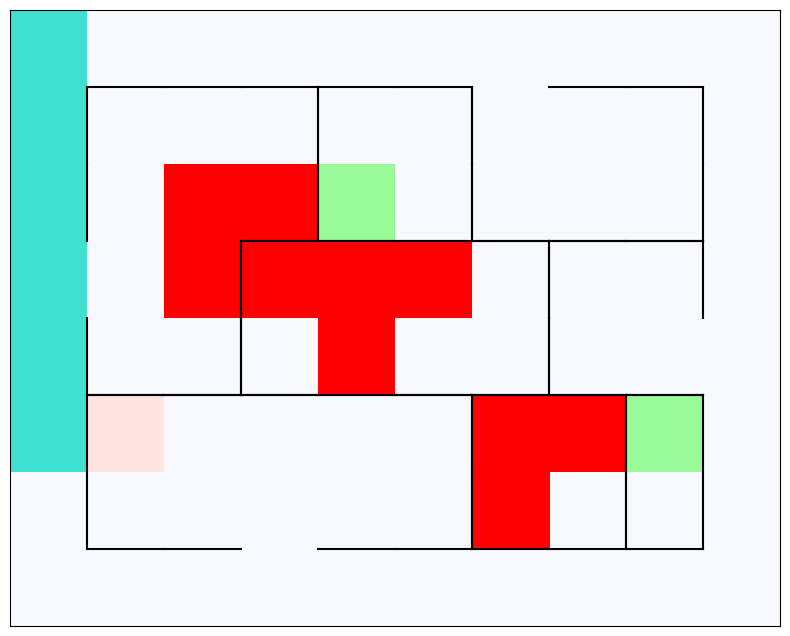

In [677]:
# Generar animación de la simulación inicial.

fig, axis = plt.subplots(figsize=(10, 8))
axis.set_xticks([])
axis.set_yticks([])

mycmap = matplotlib.colors.ListedColormap(['ghostwhite', 'turquoise', 'gold', 'gray', 'red', 'orange', 'mistyrose', 'palegreen'])

# patch = plt.imshow(all_grids.iloc[0, 0], cmap =mycmap)
# print(len(all_grids["WallGrid"][0][0]), len(all_grids["WallGrid"][0]))
extent = [-0.5, len(all_grids["WallGrid"][0][0]) - 0.5, -0.5, len(all_grids["WallGrid"][0]) - 0.5]

def animate(i):

  axis.clear()
  axis.set_xticks([])
  axis.set_yticks([])

  # Obtener el estado de las puertas en el paso actual

  # Dibujar paredes y puertas con el estado actual, incluyendo las entradas
  draw_walls(axis, all_grids["WallGrid"].iloc[i], all_grids["DoorsGrid"].iloc[i])
  

  # Mostrar los agentes
  axis.imshow(all_grids.iloc[i, 0], cmap=mycmap, interpolation="none", origin='upper', extent=extent)


anim = animation.FuncAnimation(fig, animate, frames = model.steps)
anim

In [678]:
print( all_grids["WallGrid"][0])

[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [1, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 1], [1, 1, 0, 0], [1, 0, 0, 1], [0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 1], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 0], [0, 0, 1, 1], [0, 1, 1, 0], [0, 0, 1, 1], [0, 1, 1, 0], [0, 0, 1, 0], [0, 0, 1, 1], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1], [1, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 1], [1, 1, 0, 0], [1, 0, 0, 1], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 1, 1, 0], [0, 0, 1, 1], [0, 1, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 1], [0, 1, 1, 0], [0, 0, 1, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [1, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 1], [1, 1, 0, 0], [1, 0, 0, 1], [1, 1, 0, 1], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 1, 1, 0], [0, 0, 1, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 1, 1], [0, 1, 1, 0], [0, 0, 1, 1], [0, 1, 1, 1], [0, 0, 0, 0]], [[0, 

In [682]:
# print(all_grids["WallGrid"][4][4])
# print(all_grids["DamageGrid"][4][4])
# print(all_grids["WallGrid"][5][4])
# print(all_grids["DamageGrid"][5][4])
# print(all_grids["WallGrid"][6][4])
# print(all_grids["DamageGrid"][6][4])
# print(all_grids["WallGrid"][100][4])
# print(all_grids["DamageGrid"][100][4])

# print(all_grids["DoorsGrid"][0])
# print(all_grids["WallGrid"][0])


def convert_wall_grid_to_string(wall_grid):
    result = ""
    for i in range(1, len(wall_grid)-1):
        row_strings = []
        for j in range(1, len(wall_grid[0])-1):
            # Convertir la lista de 4 elementos en una cadena de bits
            wall_string = "".join(map(str, wall_grid[i][j]))
            row_strings.append(wall_string)
        # Unir las celdas de una fila con espacios y añadir la fila al resultado
        result += " ".join(row_strings) + "\n"
    
    return result.strip()

def convert_marker_pos_to_string(marker_grid, revealed_grid):
    result = ""
    pos_strings = []
    for i in range(1, len(marker_grid)-1):
        
        for j in range(1, len(marker_grid[0])-1):
            if marker_grid[i][j] == 1 and revealed_grid[i][j] == 0:
                pos_strings.append([i,j,"f","f"])
            elif marker_grid[i][j] == 2 and revealed_grid[i][j] == 0:
                pos_strings.append([i,j,"v","f"])

            if marker_grid[i][j] == 1 and revealed_grid[i][j] == 1:
                pos_strings.append([i,j,"f","v"])
            elif marker_grid[i][j] == 2 and revealed_grid[i][j] == 1:
                pos_strings.append([i,j,"v","v"])
        
    for string in pos_strings:
        result += f"{string[0]} {string[1]} {string[2]} {string[3]}\n"

    return result.strip()


def convert_fire_pos_to_string(fire_grid):
    result = ""
    total = 0
    pos_strings = []
    for i in range(1, len(fire_grid)):
        
        for j in range(1, len(fire_grid[0])):
            if fire_grid[i][j] == 1:
                pos_strings.append([i,j,"h"])
            elif fire_grid[i][j] == 2:
                pos_strings.append([i,j,"f"])

    for string in pos_strings:
        total += 1
        result += f"{string[0]} {string[1]} {string[2]} \n"

    result = f"{total} \n{result}"
    return result.strip()


def convert_door_pos_to_string(doors_grid):
    result = ""
    total = 0
    pos_strings = []
    for i in range(1, len(doors_grid)-1):
        for j in range(1, len(doors_grid[0])-1):
            for k in range(0,3):
                
                if doors_grid[i][j][k] == 1:
                    if k == 0:
                        pos_strings.append([i-1,j, i,j,0])
                    elif k == 1:
                        pos_strings.append([i,j-1, i,j,0])

                elif doors_grid[i][j][k] == 2:
                    if k == 0:
                        pos_strings.append([i-1,j, i,j,1])
                    elif k == 1:
                        pos_strings.append([i,j-1, i,j,1])


    for string in pos_strings:
        total += 1
        result += f"{string[0]} {string[1]} {string[2]} {string[3]} {string[4]} \n"

    result = f"{total} \n{result}"
    return result.strip()


def convert_entry_points_pos_to_string(entry_points):
    result = ""
    total = 0
    for cord in entry_points:
        total += 1
        result += f"{cord[0]} {cord[1]}\n"

    result = f"{total} \n{result}"
    return result.strip()

def convert_agent_data_to_string(agent_data):
    result = ""
    total = 0
    for data in agent_data:
        total += 1
        result += f"{data[0]} {data[1]} {data[2]} \n"
    result = f"{total} \n{result}"
    return result.strip()

# Convertir la lista de paredes a la cadena deseada
wall_grid_string = convert_wall_grid_to_string(all_grids["WallGrid"][0])

markers_string =convert_marker_pos_to_string(all_grids["MarkerGrid"][0], all_grids["RevealedGrid"][0])

fire_string = convert_fire_pos_to_string(all_grids["FireGrid"][0])

door_string = convert_door_pos_to_string(all_grids["DoorsGrid"][0])

entry_points_string = convert_entry_points_pos_to_string(entry_points)

# Mostrar el resultado
# print(wall_grid_string)
# print(markers_string)
# print(fire_string)
# print(door_string)
# print(entry_points_string)

def get_end(step):
    print(all_grids["GameEnd"][step])
    if all_grids["GameEnd"][step]:
        return "true"
    return "false"

def get_json(step):
    wall_grid_string = convert_wall_grid_to_string(all_grids["WallGrid"][step])

    markers_string =convert_marker_pos_to_string(all_grids["MarkerGrid"][step], all_grids["RevealedGrid"][step])

    fire_string = convert_fire_pos_to_string(all_grids["FireGrid"][step])

    door_string = convert_door_pos_to_string(all_grids["DoorsGrid"][step])

    entry_points_string = convert_entry_points_pos_to_string(entry_points)

    agent_data_string = convert_agent_data_to_string(all_grids["AgentInfo"][0])

    jsonString = f"{wall_grid_string} \n{markers_string} \n{fire_string} \n{door_string} \n{entry_points_string} \n{agent_data_string}"

    return jsonString

print(get_json(0))

1100 1000 1001 1100 1001 0100 1000 1001
0100 0000 0011 0110 0011 0110 0010 0011
0000 0001 1100 1000 1000 1001 1100 1001
0110 0011 0110 0010 0010 0011 0110 0010
1100 1000 1000 1000 1001 1100 1001 1101
0110 0010 0000 0010 0011 0110 0011 0111 
2 4 v f
5 1 f f
5 8 v f 
10 
2 2 f 
2 3 f 
3 2 f 
3 3 f 
3 4 f 
3 5 f 
4 4 f 
5 6 f 
5 7 f 
6 6 f 
8 
1 3 1 4 0 
2 5 2 6 0 
3 2 3 3 0 
2 8 3 8 0 
4 6 4 7 0 
4 4 5 4 0 
6 5 6 6 0 
6 7 6 8 0 
4 
1 6
3 1
4 8
6 3 
6 
0 0 0 
0 1 1 
0 2 2 
0 3 3 
0 4 4 
0 5 5


In [ ]:
responseStep = 0

class Server(BaseHTTPRequestHandler):

    def do_GET(self):
        global responseStep

        path = self.path
        print("path: ", path)
        match = re.match(r'^/(\d+)$', path)
        print("match: ", match)
        if match:
            responseStep = int(match.group(1))
            print("response step: ", responseStep)

        else:
            # Si no se proporciona un número válido
            self.send_response(200)
            self.send_header('Content-type', 'application/json')
            self.end_headers()

            responseStep += 1
            end = get_end(responseStep)
            content = get_json(responseStep)
            # Crear la respuesta en formato JSON
            response = {
                "step" : responseStep,
                "content" : content,
                "end" : end
            }

            response_json = json.dumps(response)

            self.wfile.write(response_json.encode('utf-8'))
            return

        # self._set_response()
        self.send_response(200)
        self.send_header('Content-type', 'application/json')
        self.end_headers()

        end = get_end(responseStep)
        content = get_json(responseStep)
        # Crear la respuesta en formato JSON
        response = {
            "step" : responseStep,
            "content" : content,
            "end" : end
        }

        response_json = json.dumps(response)


        self.wfile.write(response_json.encode('utf-8'))



def run(server_class=HTTPServer, handler_class=Server, port=8585):
    logging.basicConfig(level=logging.INFO)
    server_address = ('', port)
    httpd = server_class(server_address, handler_class)
    logging.info(f"Starting httpd in port {port}...\n") # HTTPD is HTTP Daemon!
    try:
        httpd.serve_forever()
    except KeyboardInterrupt:   # CTRL+C stops the server
        pass
    httpd.server_close()
    logging.info("Stopping httpd...\n")

run()

INFO:root:Starting httpd in port 8585...



path:  /
match:  None
False


127.0.0.1 - - [26/Nov/2024 17:59:27] "GET / HTTP/1.1" 200 -
INFO:root:Stopping httpd...

